In [1]:
import sys
import pandas as pd
sys.path.append('../..')

# Creature

In [2]:
from lamarck import Creature

In [3]:
genome = {
    'x': 10,
    'y': 'A',
    'z': (1, 2, 3)
}

In [4]:
creature = Creature(genome)

In [5]:
creature.id

-9172460574246273952

# Genome Creator

In [6]:
from lamarck.assistant import GenomeCreator

In [7]:
genome_creator = GenomeCreator()

In [8]:
genome_creator.add_gene_specs.numeric(name='x',
                                      min=0,
                                      max=10,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.categorical(name='y', domain=['A', 'B', 'C', 'D', 'E'])

genome_creator.add_gene_specs.vectorial(name='z', length=4, replace=False, domain=['i', 'j', 'k', 'l', 'm'])

In [9]:
genome_blueprint = genome_creator.get_genome_blueprint()

In [10]:
genome_blueprint

{'x': {'type': 'numeric',
  'domain': 'int',
  'ranges': {'min': 0, 'max': 10, 'progression': 'linear'}},
 'y': {'type': 'categorical', 'domain': ['A', 'B', 'C', 'D', 'E']},
 'z': {'type': 'vectorial',
  'domain': ['i', 'j', 'k', 'l', 'm'],
  'ranges': {'length': 4, 'replace': False}}}

# Population Creator

In [11]:
from lamarck.assistant import PopulationCreator

In [12]:
pop_creator = PopulationCreator(genome_blueprint)

In [13]:
popdet = pop_creator.create.det(10)
popdet

Population with 1000 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [14]:
popdet.datasets.main.head()

,x,y,z
0,0,A,"(i, j, k, l)"
1,0,A,"(i, l, j, k)"
2,0,A,"(j, i, k, l)"
3,0,A,"(j, l, i, k)"
4,0,A,"(k, i, j, l)"


In [15]:
poprand = pop_creator.create.rand(2000)
poprand

Population with 2000 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [16]:
poprand.datasets.input.head()

,x,y,z
id,,,
8294524176853775526,8,A,"(k, i, j, l)"
-8906509120665561874,6,A,"(l, j, m, i)"
6570397478213790349,3,B,"(m, k, l, i)"
4569939768953436282,2,D,"(l, i, k, m)"
5133249341769049665,3,C,"(l, k, j, m)"


In [17]:
popdirty = popdet + poprand
popdirty

Population with 3000 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [18]:
popdirty.datasets.input.head()

,x,y,z
id,,,
542931523618533034,0,A,"(i, j, k, l)"
-7965149156412566910,0,A,"(i, l, j, k)"
223602513353997060,0,A,"(j, i, k, l)"
6542885083425974226,0,A,"(j, l, i, k)"
5736695986599492712,0,A,"(k, i, j, l)"


In [19]:
pop = popdirty.drop_duplicates()
pop

Population with 2088 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [20]:
pop.datasets.input.head()

,x,y,z
id,,,
542931523618533034,0,A,"(i, j, k, l)"
-7965149156412566910,0,A,"(i, l, j, k)"
223602513353997060,0,A,"(j, i, k, l)"
6542885083425974226,0,A,"(j, l, i, k)"
5736695986599492712,0,A,"(k, i, j, l)"


# Environment

In [21]:
from lamarck import Environment

In [22]:
import hashlib

def tuplehash(tuple_obj):
    encoded = ''.join(tuple_obj).encode()
    m = hashlib.md5()
    m.update(encoded)
    d = m.digest()
    return int.from_bytes(d, 'big')
    
    
def dummy_process(x, y, z):
    zval = (tuplehash(z) % 1000) / (x+1)**0.75
    yval = zval // ord(y) + tuplehash((y, y)) % 73
    return {
        'time': (x + 1) * abs(zval - yval) // 10,
        'profit': (abs(3*zval - 2*yval)**((int(x/10) + 1) % 9) // (tuplehash((y, y)) % 7 + 1)) % 10000 + (zval*yval) //10
    }

In [23]:
env = Environment()

In [24]:
env.config.set_process(dummy_process)

In [25]:
env.config.set_output_varibles('time', 'profit')

In [26]:
env.config

multi:   False
output_varibles:   ('time', 'profit')
process:   <function dummy_process at 0x7f7eb9afee50>

In [27]:
cr = pop[10]
cr

Creature <7887109905415858503> - genome: {'x': 0, 'y': 'B', 'z': ('i', 'j', 'k', 'l')}

### Simulate Creature

In [28]:
env.simulate(cr)

{'time': 93.0, 'profit': 6323.0}

### Simulate Population

In [29]:
simpop = env.simulate(pop)

In [30]:
simpop

Population with 2088 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [31]:
simpop.datasets.output.head()

,x,y,z,time,profit
542931523618533034,0,A,"(i, j, k, l)",95.0,2154.0
-7965149156412566910,0,A,"(i, l, j, k)",52.0,877.0
223602513353997060,0,A,"(j, i, k, l)",25.0,325.0
6542885083425974226,0,A,"(j, l, i, k)",76.0,1492.0
5736695986599492712,0,A,"(k, i, j, l)",16.0,171.0


### Simulate Population - Multi Thread

In [32]:
env.config.set_multi(True)

In [33]:
simpop = env.simulate(pop)

In [34]:
simpop.datasets.output.head()

,x,y,z,time,profit
542931523618533034,0,A,"(i, j, k, l)",95.0,2154.0
-7965149156412566910,0,A,"(i, l, j, k)",52.0,877.0
223602513353997060,0,A,"(j, i, k, l)",25.0,325.0
6542885083425974226,0,A,"(j, l, i, k)",76.0,1492.0
5736695986599492712,0,A,"(k, i, j, l)",16.0,171.0


# Fitness

### 1. Single Objective

In [35]:
single_objective_pop = simpop.apply_fitness.single_objective(output='time', objective='min')

In [36]:
single_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria
-5538914151308544193,4,D,"(m, i, l, j)",0.0,30.0,0.0
-5096365466556244860,9,B,"(i, m, j, l)",0.0,70.0,0.0
-7589947723795314722,6,C,"(j, i, l, k)",0.0,27.0,0.0
-8604012161182819051,2,E,"(m, i, j, k)",0.0,227.0,0.0
2377402673788899501,2,D,"(l, j, m, k)",0.0,32.0,0.0


### 2. Multi Objective - Ranked

In [37]:
ranked_objective_pop = simpop.apply_fitness.multi_objective.ranked(priorities=['time', 'profit'], objectives=['min', 'max'])

In [38]:
ranked_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1
3197059580375836267,0,E,"(k, i, j, m)",0.0,250.0,0.0,250.0
-2065288120216104673,5,E,"(j, m, i, l)",0.0,234.0,0.0,234.0
-3057822455511788362,6,E,"(l, m, i, j)",0.0,232.0,0.0,232.0
-2984182562697091939,7,E,"(m, l, k, i)",0.0,229.0,0.0,229.0
-8604012161182819051,2,E,"(m, i, j, k)",0.0,227.0,0.0,227.0


### 3. Multi Objective - Pareto

In [39]:
pareto_objective_pop = simpop.apply_fitness.multi_objective.pareto(outputs=['time', 'profit'], objectives=['min', 'max'])

In [40]:
pareto_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1,front,crowd
5776818401083006746,0,E,"(m, i, j, k)",5.0,552.0,5.0,552.0,1,0.25
-7841215949029579744,1,E,"(m, i, j, k)",3.0,315.0,3.0,315.0,1,0.25
-8604012161182819051,2,E,"(m, i, j, k)",0.0,227.0,0.0,227.0,1,0.25
-676592647545764375,7,B,"(m, i, j, k)",0.0,71.0,0.0,71.0,1,0.25
6302673481129065545,10,B,"(j, i, k, l)",24.0,7949.0,24.0,7949.0,1,0.25


<AxesSubplot:xlabel='time', ylabel='profit'>

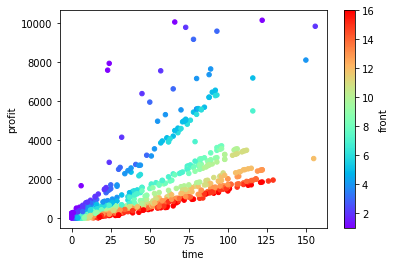

In [41]:
pareto_objective_pop.plot_fronts('time', 'profit')

# Selection